# Tutorial: Basics classifiers

In this lab we will get more comfortable configuring various classifiers in R.

## Goals:
* Learn to use the `glm` function for logistic regression
* Learn to use the `lda` and `qda` functions for doing discriminant analysis

This tutorial draws from the practice sets at the end of Chapter 4 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

---
# Logistic regression with glm

For the first part of the lab we will use the generalized linear model (`glm`) function to perform logistic regression. [GLM](https://en.wikipedia.org/wiki/Generalized_linear_model) is a way of formalizing all forms of linear models when the underlying statistical distribution is part of the [exponential family](https://en.wikipedia.org/wiki/Exponential_family). The linear regression models we have discussed so far in this class are a type of *GLM*, and logistic regression also falls under the *GLM* umbrella.


## Predicting the stock market

For the logistic regression exercises, we will use the S&P stock market data included with the ISLR library.

This dataset contains daily observations (n=1250) for the S&P 500 index between 2001 & 2005. The variables in this data set include:

* **Year:** The year that the observation was recorded

* **Lag1:** Percentage return for previous day

* **Lag2:** Percentage return for 2 days previous

* **Lag3:** Percentage return for 3 days previous

* **Lag4:** Percentage return for 4 days previous

* **Lag5:** Percentage return for 5 days previous

* **Volume:** Volume of shares traded (number of daily shares traded in billions)

* **Today:** Percentage return for today

* **Direction:** A factor with levels Down and Up indicating whether the market had a positive or negative return on a given day

Remember that logistic regression, and classification more generally, is about working with categorical output variables. Guess which of the variables above is the one we'll be predicting! 




In [ ]:
# Install the ISLR package (if you haven't yet) 
install.packages("ISLR")

# Load the library
library(ISLR)
library(ggplot2)

# Uncomment the line below if you want to learn more about the dataset
#help(Smarket)

# Let's take a look at the distribution of our variables
summary(Smarket)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



      Year           Lag1                Lag2                Lag3          
 Min.   :2001   Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.922000  
 1st Qu.:2002   1st Qu.:-0.639500   1st Qu.:-0.639500   1st Qu.:-0.640000  
 Median :2003   Median : 0.039000   Median : 0.039000   Median : 0.038500  
 Mean   :2003   Mean   : 0.003834   Mean   : 0.003919   Mean   : 0.001716  
 3rd Qu.:2004   3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.596750  
 Max.   :2005   Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.733000  
      Lag4                Lag5              Volume           Today          
 Min.   :-4.922000   Min.   :-4.92200   Min.   :0.3561   Min.   :-4.922000  
 1st Qu.:-0.640000   1st Qu.:-0.64000   1st Qu.:1.2574   1st Qu.:-0.639500  
 Median : 0.038500   Median : 0.03850   Median :1.4229   Median : 0.038500  
 Mean   : 0.001636   Mean   : 0.00561   Mean   :1.4783   Mean   : 0.003138  
 3rd Qu.: 0.596750   3rd Qu.: 0.59700   3rd Qu.:1.6417   3rd Qu.: 0.596750  
 Max. 

In [ ]:
# Next let's quantify all pairwise correlations as a first glimpse at the relationships among the variables 
cxy = cor(Smarket)

ERROR: ignored

The code above returns an error - this is because calculating the correlations requires numeric variables, but the `Direction` variable is categorical. 

In [ ]:
# Look at the column for Direction
head(Smarket$Direction)

[1] Up   Up   Down Up   Up   Up  
Levels: Down Up

In [ ]:
# In order to see the correlation let's remove the Direction variable
cxy = cor(Smarket[,-which(colnames(Smarket)=="Direction")]) 
cxy

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00000000,0.029699649,0.030596422,0.033194581,0.035688718,0.029787995,0.53900647,0.030095229
Lag1,0.02969965,1.000000000,-0.026294328,-0.010803402,-0.002985911,-0.005674606,0.04090991,-0.026155045
Lag2,0.03059642,-0.026294328,1.000000000,-0.025896670,-0.010853533,-0.003557949,-0.04338321,-0.010250033
Lag3,0.03319458,-0.010803402,-0.025896670,1.000000000,-0.024051036,-0.018808338,-0.04182369,-0.002447647
Lag4,0.03568872,-0.002985911,-0.010853533,-0.024051036,1.000000000,-0.027083641,-0.04841425,-0.006899527
Lag5,0.02978799,-0.005674606,-0.003557949,-0.018808338,-0.027083641,1.000000000,-0.02200231,-0.034860083
Volume,0.53900647,0.040909908,-0.043383215,-0.041823686,-0.048414246,-0.022002315,1.00000000,0.014591823
Today,0.03009523,-0.026155045,-0.010250033,-0.002447647,-0.006899527,-0.034860083,0.01459182,1.000000000


This gives us a sense of the relationship between the variables. While Volume and Year appear to be correlated (r=0.539) the rest of the variables appear to be weakly correlated at best.

So now, let's use the built-in _glm_ function to estimate the following model.
$$ y_{direction} = \beta_0 + \beta_1 x_{lag1} + \beta_2 x_{lag2} + \beta_3 x_{lag3} +\\
 \beta_4 x_{lag4} + \beta_5 x_{lag5} + \beta_{6} x_{Volume} + \epsilon $$

This model tries to predict whether the stock market will end higher or lower on one day given the percent returns on the previous 5 days and the overall volume of shares traded.

For this analysis we need to define how $Y$ (Direction) is distributed. For logistic regression we say that $Y$ is binomially distributed (i.e., it arises from a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)).

In [ ]:
# Run the GLM
glm.fit=glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume, data=Smarket, family=binomial) # logistic regression 

# Summarize
summary(glm.fit)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Smarket)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.446  -1.203   1.065   1.145   1.326  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.126000   0.240736  -0.523    0.601
Lag1        -0.073074   0.050167  -1.457    0.145
Lag2        -0.042301   0.050086  -0.845    0.398
Lag3         0.011085   0.049939   0.222    0.824
Lag4         0.009359   0.049974   0.187    0.851
Lag5         0.010313   0.049511   0.208    0.835
Volume       0.135441   0.158360   0.855    0.392

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1731.2  on 1249  degrees of freedom
Residual deviance: 1727.6  on 1243  degrees of freedom
AIC: 1741.6

Number of Fisher Scoring iterations: 3


As you can see, if we accept an $\alpha = 0.05$ (i.e., p must be less than 0.05 for the effect to be statistically significant), then it doesn't appear that the previous day's performance or overall trading volume predicts whether the market ends up or down on a given day.

Let's take a closer look at the model fits themselves.

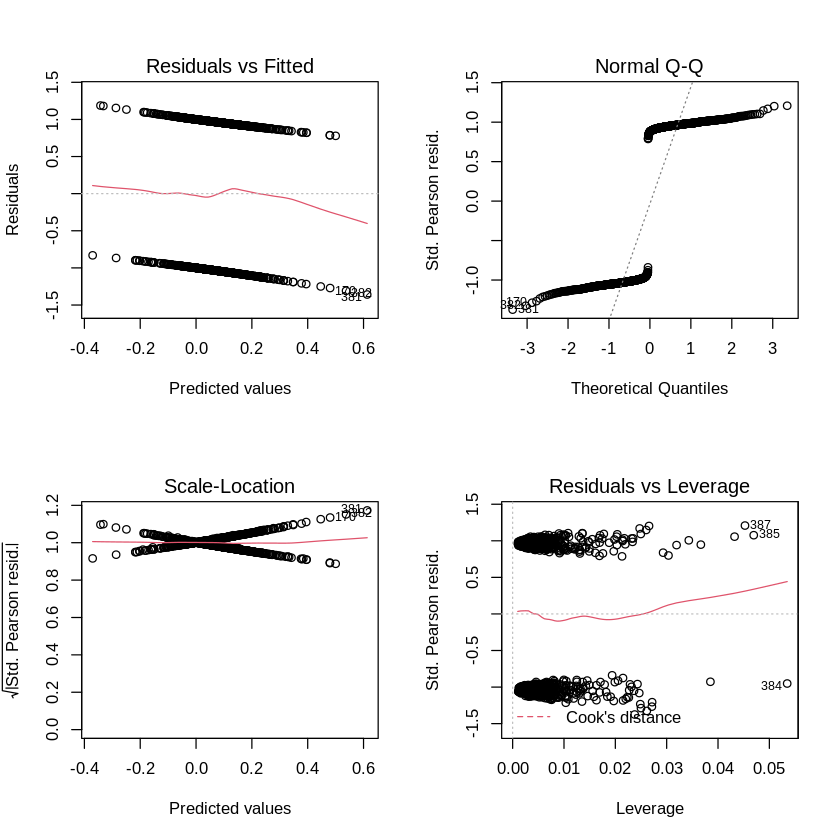

In [ ]:
# Plot the model fit evaluation images
par(mfrow=c(2,2))
plot(glm.fit)

It appears that there are some high leverage points. But clearly, most of the other model fit evaluations that we used for linear regression don't work for the logistic family.

We can also test the quality of the model fit itself. How do we do that? Use _prediction_.

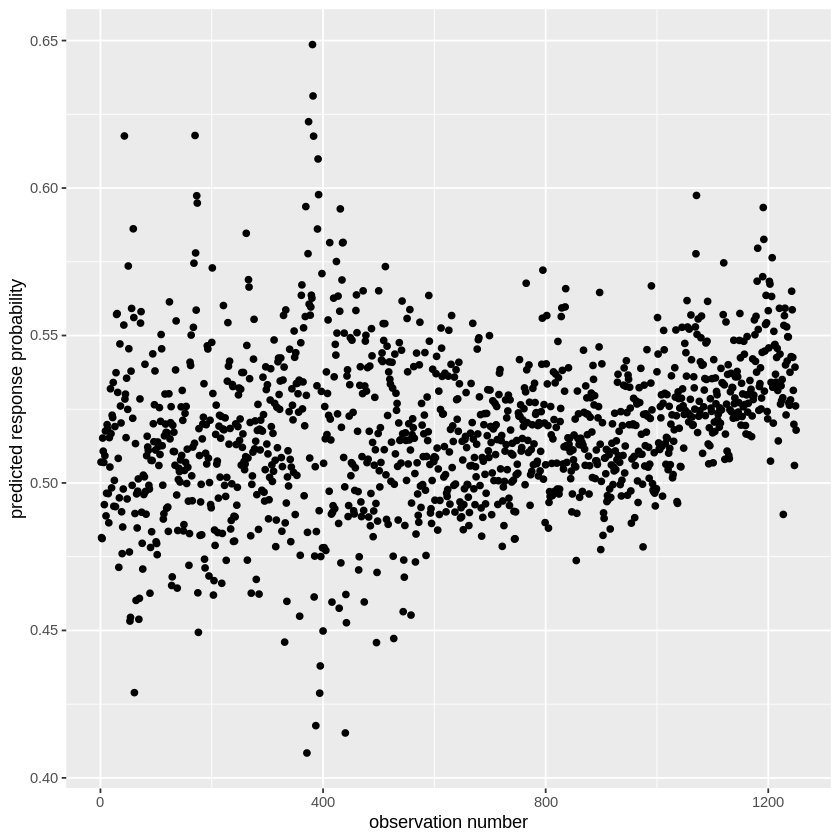

In [ ]:
# See how well the model captured the training set
glm_prob_df = data.frame(predict(glm.fit, type = "response"))
colnames(glm_prob_df) = c('predicted_prob')

num_observations = nrow(glm_prob_df)
glm_prob_df$index = seq(1, num_observations) #get the observation number for plotting; ggplot does not infer this

# Setting type="response" tells R to output prob. from P(Y=1,X) for all values of X
# "If no data set is supplied to the predict() function, then the probabilities 
# are computed for the training data that was used to fit the logistic regression model."

ggplot(glm_prob_df, aes(index, predicted_prob)) + geom_point() + xlab('observation number') + ylab('predicted response probability') 

What we are showing here are the predicted Y values for our full model. Notice that they are not binary. Why? Because we are estimating Y as a sigmoid function, as we talked about during the lecture. Thus we aren't predicting the direction, but the *probability* of the direction being "Up". We know that these are the probabilities that the Stock Market will go **up** rather than down because we can check how R categorized the Direction variable using `contrasts()`.

In [ ]:
contrasts(Smarket$Direction)

,Up
Down,0
Up,1


Thus, if you want to make a binary prediction (i.e., did the market go up or down?), you need to set a _threshold_ for the estimated outcome probability and binarize the result according to that threshold. Let's try that.

In [ ]:
threshold = 0.50 #binarizing threshold 

# First make a list of "Downs"
glm_prob_df$predicted_binary=rep("Down",num_observations)

# Then use the probability output to label the up days. Let's use a threshold of 50% probability. 
glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>threshold]="Up" #find the rows that have prob > threshold and cast as 'up'

# Now let's look at the prediction accuracy
confusion_df = data.frame(glm_prob_df$predicted_binary, Smarket$Direction)
colnames(confusion_df) = c('predicted', 'actual')

table(confusion_df)

         actual
predicted Down  Up
     Down  145 141
     Up    457 507

This table is sometimes call the _confusion matrix_. The diagonal values (top left and bottom right) are the frequency of the correct predictions and the off diagonal (top right and bottom left) are the errors. We can estimate the overall accuracy by either summing the diagonal values and dividing by $n$, the total number of observations, (i.e., (`145+507)/1250`) or more directly by seeing the average number of times the predicted value matched the observed.

*Side note: you can create nicely formatted confusion matrices using the caret package and the [fourfoldplot command](https://medium.com/@verajosemanuel/fourfoldplot-a-prettier-confusion-matrix-in-base-r-1a6f7a3176d4), though I find the simple table easier to interpret.*

In [ ]:
# We can calculate the prediction accuracy by counting the number of times our
# prediction vector matched the real data and taking the average
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

[1] "Accuracy: 0.5216"


This means that we are correct ~52% of the time in estimating whether the market will end up or down on a given day. At first glance this might not seem that bad (it's better than chance, 50%). However, remember, this is the error on the _training_ data. So the actual performance of this model at predicting the stock market in the future (i.e., _test_ accuracy) may be lower.

Let's try a case where we try to predict the market performance in 2005, using the pre-2005 data.

In [ ]:
# Let's isolate the years before 2005 to use as a training set to predict market change in 2005

# First create an index vector to find the entries corresponding to years < 2005
train_idx=(Smarket$Year<2005)


# Can now make a whole new Smarket dataset just for 2005 (it's the last year, so anything not train is 2005)
Smarket.2005_test = Smarket[!train_idx,] #find rows that do not (! = not) occupy the training data indices

dim(Smarket.2005_test) #get dimensions of the test data 

# Now let's extract the Direction for just 2005
Direction.2005_test=Smarket.2005_test$Direction

[1] 252   9

For the sake of simplicity, let's only use performance from the previous two days to predict the current stock market peformance. In other words, we'll use this model:
$$ y_{direction} = \beta_0 + \beta_1 x_{lag1} + \beta_2 x_{lag2} + \epsilon $$


In [ ]:
# Train the logistic model, but use only the subset of the data from pre-2005 (i.e., training data)
glm.fit=glm(Direction~Lag1+Lag2, data=Smarket, family=binomial, subset=train_idx) #give the training indices to the glm function 

# Predict the 2005 performance from the model trained on the pre-2005 data
glm.probs=predict(glm.fit, Smarket.2005_test, type="response")
glm.pred=rep("Down",nrow(Smarket.2005_test)) # There are only 252 observations in the test set.
glm.pred[glm.probs>0.5]="Up" #binarize the result


confusion_df = data.frame(glm.pred, Direction.2005_test) #create confusion df
colnames(confusion_df) = c('predicted', 'actual')

# Show the confusion matrix
table(confusion_df)

         actual
predicted Down  Up
     Down   35  35
     Up     76 106

In [ ]:
# Now let's look at the overall test accuracy
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

[1] "Accuracy: 0.55952380952381"


So this isn't too bad. We can predict slightly above chance the 2005 performance from a model trained on the previous years.

---
# LDA

Let's now move on to using LDA. The `lda` function is built into the MASS library that we have used previously. We'll use that one here (although there are other LDA libraries that you can install if you'd like).

First let's replicate our prediction problem using the stock market data.

Call:
lda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train_idx)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

Coefficients of linear discriminants:
            LD1
Lag1 -0.6420190
Lag2 -0.5135293

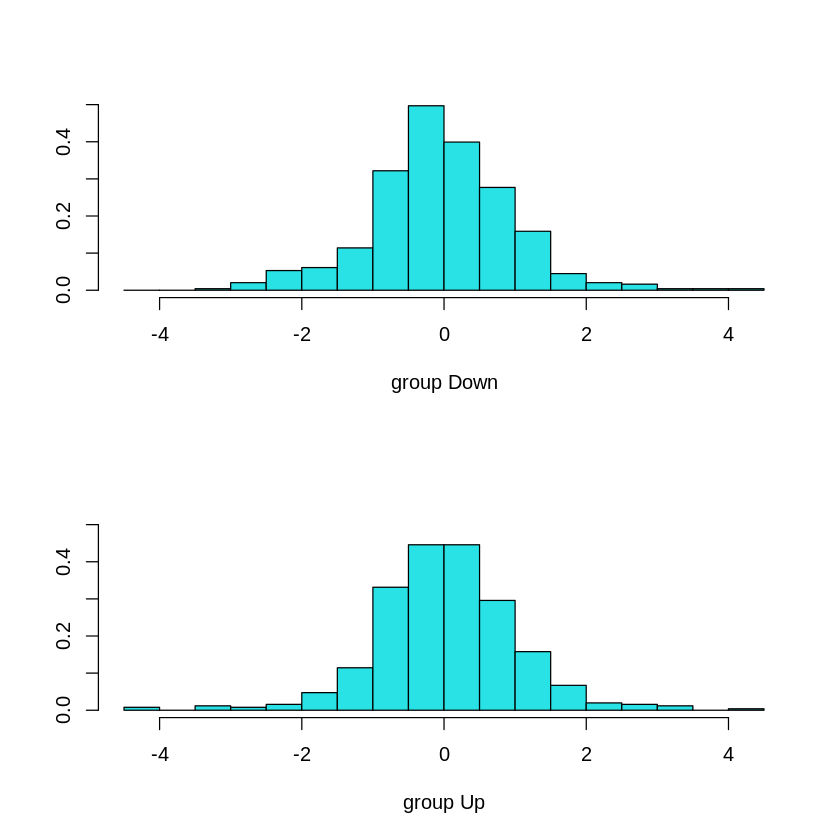

In [ ]:
library(MASS)

# LDA syntax is just like for linear regression fitting 
# Let's conduct LDA on the training subset now
lda.fit = lda(Direction~Lag1+Lag2, data=Smarket, subset=train_idx)
lda.fit # The summary() function gives you something different
plot(lda.fit)


This indicates that 49.2% of the training observations correspond to days during which the market went down. 

The coefficients of linear discriminants indicate the distance of each value from
the discrimination boundary.

1. If $w_1*x_{Lag1} - w_2*x_{Lag2}$ is positive, then the classifier predicts the market will increase 
2. If $w_1*x_{Lag1} - w_2*x_{Lag2}$ is negative, then the classifier predicts the market will decrease

Now let's use LDA to predict the market values in 2005. LDA determines the group assignment by assigning above and below the 50% (0.5) posterior probabiltiy. In otherwords if the posterior probability is >=0.5, then it assigns one value, otherwise it assigns the other.

In [ ]:
# Predict from your LDA coefficients
lda.pred = predict(lda.fit, Smarket.2005_test)

# We next extract the output of the prediction 
lda.class = lda.pred$class
table(lda.class, Direction.2005_test)
print(paste("Accuracy:",mean(lda.class==Direction.2005_test)))

         Direction.2005_test
lda.class Down  Up
     Down   35  35
     Up     76 106

[1] "Accuracy: 0.55952380952381"


So we now see that the LDA is performing just as well as the logistic regression at ~56% test set accuracy.

Another way to evaluate the LDA is by looking at the posterior probability from the model. This is analogous (although not identical) to $\hat{y}$, our estimate of the probability of being "Up", in the logistic regression example. 

In [ ]:
head(lda.pred$posterior)

,Down,Up
999,0.4901792,0.5098208
1000,0.4792185,0.5207815
1001,0.4668185,0.5331815
1002,0.4740011,0.5259989
1003,0.4927877,0.5072123
1004,0.4938562,0.5061438


Sometimes it is more informative to look at the relationship between a predictor variable and the posterior, rather than a predictor variable and the predicted classification. It helps you distinguish between, for example, observations that are *very* likely to be "Down" and observations that are only somewhat likely to be "Down".

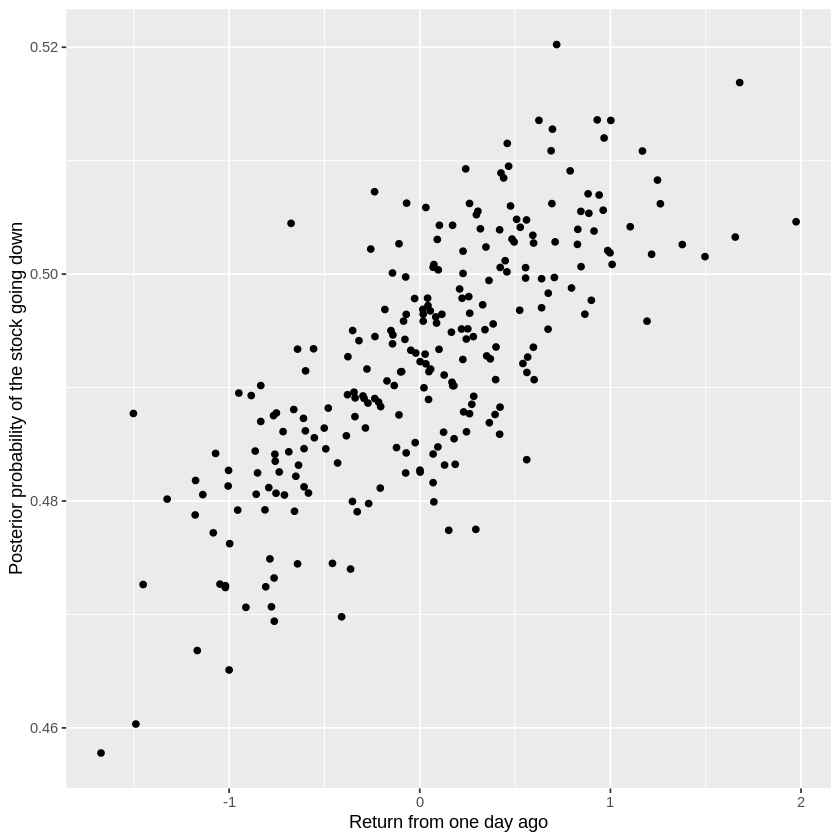

In [ ]:
# Show the relationship between the Lag 1 variable 
# and the posterior probability from LDA

lag1_posterior_df = data.frame(Smarket.2005_test$Lag1, lda.pred$posterior[,1])
colnames(lag1_posterior_df) = c('lag1_return', 'down_posterior_prob')

ggplot(data=lag1_posterior_df, aes(lag1_return, down_posterior_prob)) + geom_point() + xlab('Return from one day ago') + ylab('Posterior probability of the stock going down')
#getting the lag 1 percentage return & the posterior prob. of the stock going down

---
# QDA

Remember that QDA is a special case of LDA where you do not assume that the underlying distributions have equal variances. So let's use QDA for the same problem we have been working on so far. First off, let's check how the distributions of `Lag1` and `Lag2` look in the case of `Direction="Up"` and `Direction="Down"`. This will help us think about whether QDA might be a better tool than LDA for our question. 

[1] "Covariance of Lag1, Lag2 for Up observations: -0.0278734923872115"
[1] "Covariance of Lag1, Lag2 for Down observations: -0.0392480610374496"


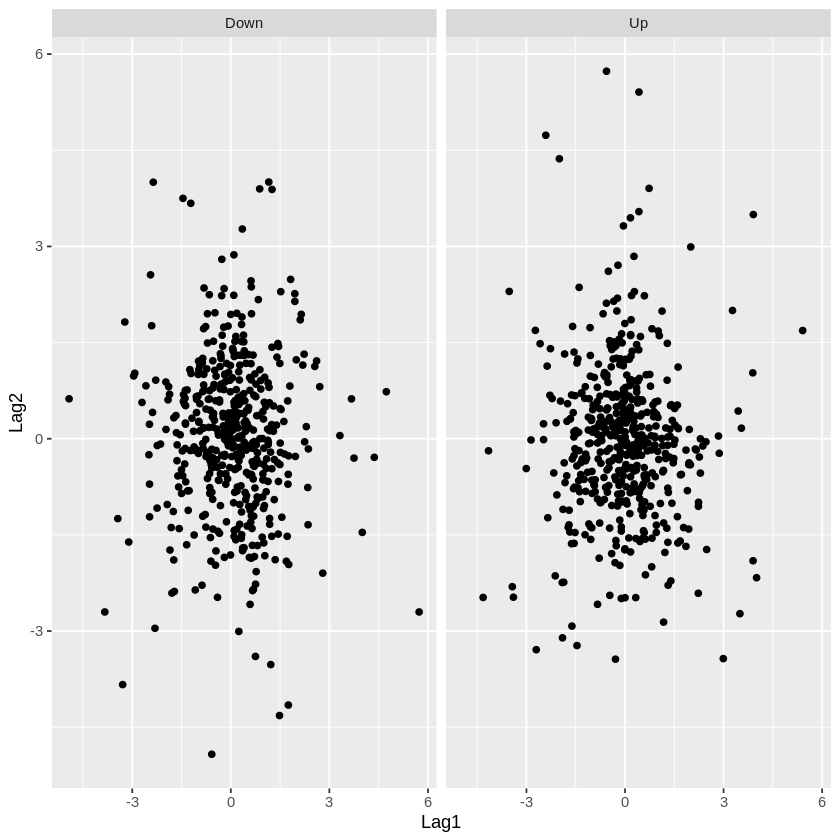

In [ ]:
ggplot(Smarket[train_idx,],aes(x=Lag1,y=Lag2)) + geom_point() + facet_grid(.~Direction)

print(paste("Covariance of Lag1, Lag2 for Up observations:",
  cov(Smarket$Lag1[train_idx][which(Smarket$Direction[train_idx]=="Up")],Smarket$Lag2[train_idx][which(Smarket$Direction[train_idx]=="Up")])))
print(paste("Covariance of Lag1, Lag2 for Down observations:",
  cov(Smarket$Lag1[train_idx][which(Smarket$Direction[train_idx]=="Down")],Smarket$Lag2[train_idx][which(Smarket$Direction[train_idx]=="Down")])))


There is definitely a fair amount of overlap in these distribution (which helps us understand why all our classifiers have low accuracy: the means of the two distributions, $\mu_{1}$ and $\mu_{2}$, are very close). However, the main advantage of QDA is allowing for differences in *variance* of the two distributions. Looking at the clusters and statistics above, the "Down" observations might have a slightly more negative covariance than the "Up" observations. Note that since there are only two predictor variables here, `Lag1` and `Lag2`, covariance is a single value instead of a matrix (like $\Sigma_k$ described in Chapter 4 of the James et al., 2013 text). 

Now that there's a possibility QDA could help, let's try it: 

In [ ]:
# QDA is also part of the MASS library
qda.fit = qda(Direction~Lag1+Lag2, data=Smarket, subset=train_idx)
qda.fit

# Same basic predictions as LDA, just assuming that each distribution has its own variance. 
# But we work with coefficients the same way.
qda.class=predict(qda.fit, Smarket.2005_test)$class
table(qda.class, Direction.2005_test)
print(paste("Accuracy:",mean(qda.class==Direction.2005_test)))

Call:
qda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train_idx)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

         Direction.2005_test
qda.class Down  Up
     Down   30  20
     Up     81 121

[1] "Accuracy: 0.599206349206349"


Notice that QDA is doing slightly better than LDA, with a test accuracy of 60%. 

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, Patience Stevens, and Amy Sentis.*